In [0]:
import numpy as np
import math
import torch
import torchvision
import torchvision.transforms as transforms

In [0]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


plane


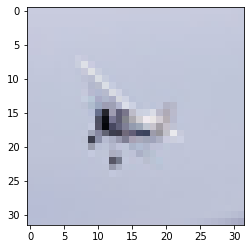

In [0]:
#https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
#Let us show some of the training images, for fun.
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)whe
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(1)))

In [0]:
#getting the x(2d matrix of 50000*3072, input images), and y(1*3072, output label);
tmpTrain = trainloader.dataset.data # shape of 50000*32*32*3 need to transform to 50000*3072
x,y1,y2,y3 = tmpTrain.shape
trainX = np.zeros([x, y1*y2*y3])
tmpTrainY = trainloader.dataset.targets
trainY = np.zeros([len(tmpTrainY), len(classes)])
for i in range(len(tmpTrainY)):
  trainY[i][tmpTrainY[i]] = 1
tmpTest = testloader.dataset.data # shape of 10000*32*32*3 need to transform to 10000*3072
xx, y4, y5, y6 = tmpTest.shape
testY = testloader.dataset.targets
testX = np.zeros([xx, y4*y5*y6])
for i in range(x):
  trainX[i] = tmpTrain[i].flatten()

trainX = trainX / np.linalg.norm(trainX) 
for j in range(xx):
  testX[j] = tmpTest[j].flatten()

testX = testX / np.linalg.norm(testX)

print("the shape of matrix trainX" + str(trainX.shape))
print("the size of trainY " + str(trainY.shape))
print("the shape of matrix testX" + str(testX.shape))
print("the size of testY " + str(len(testY)))
print(trainX[15])




the shape of matrix trainX(50000, 3072)
the size of trainY (50000, 10)
the shape of matrix testX(10000, 3072)
the size of testY 10000
[5.90271027e-05 9.91655325e-05 1.36352607e-04 ... 9.56239063e-05
 1.09200140e-04 1.19234747e-04]


In [0]:
#activation functions

def softmax(x):
  N,D = x.shape
  x_exp = np.exp(x - np.max(x, 1)[:, None])
  return x_exp / np.sum(x_exp, axis=-1)[:, None]

def relu(x):
  N, D = x.shape
  ans = np.zeros([N,D])
  for i in range(N):
    for j in range(D):
      if x[i][j] > 0:
        ans[i][j] = x[i][j]
      else:
        ans[i][j] = 0
  return ans

def sigmoid(x):
  N, D = x.shape
  ans = np.zeros([N,D])
  for i in range(N):
    for j in range(D):
      try:
        ans[i][j] = 1/(1+math.exp(-x[i][j]))
      except OverflowError:
        if(x[i][j])>0:
          ans[i][j] = 1
        else:
          ans[i][j] = 0
  return ans


In [0]:
#define weights for different layers, put them in a list called Ws, each weight has a shape of size(l-1)*size(l)
layerNumber = [1024,500, 250, 100, 50] #number of hidden layers and number of nodes in each layer
AV = relu #activation function that we use 
Ws = []
N,D = trainX.shape
start = D
N,DD =trainY.shape
end = layerNumber[0]
w = np.random.randn(start, end)*0.1
Ws.append(w)
for i in range(len(layerNumber)):
  start = layerNumber[i]
  if i+1 == len(layerNumber):
    end = DD
  else:
    end = layerNumber[i+1]
  w = np.random.randn(start, end)*0.1
  print(w)
  Ws.append(w)

[[-0.02020017 -0.0473346   0.01619799 ... -0.1519765  -0.06750742
  -0.01637885]
 [-0.20427042  0.18051736 -0.12863867 ...  0.15860771  0.04302559
   0.03089472]
 [ 0.20270583 -0.18686559  0.02499393 ...  0.12043391 -0.03535105
  -0.06132815]
 ...
 [ 0.07723723 -0.07910859 -0.15796359 ...  0.10118639  0.0644508
   0.03153392]
 [-0.00296351 -0.11422695  0.0124831  ... -0.11250304  0.04482932
   0.07644653]
 [ 0.04892095 -0.13914393  0.05817503 ... -0.12813211 -0.09102716
  -0.03780532]]
[[ 0.02904964 -0.15738052 -0.02948124 ... -0.021968    0.09762052
   0.03025009]
 [-0.18133008 -0.06522825 -0.03372895 ... -0.03051499 -0.01470971
   0.05517556]
 [ 0.04133676  0.03938828  0.07773676 ... -0.07151395  0.09996774
   0.01198206]
 ...
 [ 0.14403999  0.15277254 -0.04887396 ... -0.09693464 -0.13624064
  -0.07910791]
 [-0.04154621  0.07305518  0.06964413 ... -0.00649738 -0.05041861
   0.16593114]
 [ 0.01068499 -0.11373006  0.10961665 ... -0.04163874  0.0910338
   0.04591366]]
[[-0.08207551 -0.0

In [0]:
Zs = [] #hidden layers

def getYhead(X):
  Y = []
  N,D = X.shape
  Zs.clear()
  for layer in layerNumber:
    Zs.append(np.zeros([N,layer]))
  Yhead = np.zeros([N, len(classes)])
  tmp = X
  for i in range(len(Ws)-1):
    NN,DD = tmp.shape
    tmp = AV(np.dot(tmp, Ws[i])) #Doing activation function for the Zs in layer
    Zs[i] = tmp
  Y = softmax(np.dot(tmp, Ws[len(Ws)-1])) #Doing softmax for final layer since it is multiclass classification
  return Y



In [0]:
#Cost of one training result
def cost(Y1, Y2):
  total = 0.0
  for i in range(len(Y1)):
    value = (Y1[i]-Y2[i])*(Y1[i]-Y2[i])
    total = total + value
  return total


#Average cost of all training result
def averageCost(Y1, Y2):
  N,D = Y1.shape
  total = 0.0
  for i in range(N):
    total = total + cost(Y1[i],Y2[i])
  return total/N

In [0]:


def gradient(X, Y):
  N,D = X.shape
  Yh = getYhead(X)
  print("Average cost so far " + str(averageCost(Yh, Y)))
  dY = (Yh - Y)
  dZnext =dY
  WsReversed = Ws.copy()
  ZsReversed = Zs.copy()
  WsReversed.reverse() #reverse them since we need to calculate the dw from last layer to the first layer
  ZsReversed.reverse()
  dWs =[]
  w = WsReversed[0]
  z = ZsReversed[0]
  dW = np.dot(z.T, dZnext)
  #Probably the problem come from here, I am trying to calculate the dWeight between last hidden layer and final layer
  #now z is the last hidden layer, Yh is the final answer, in the video, derivative of w = al-1*(derivative of sigmoid)*dy
  #al-1 is last hidden layer, Yh*(1-Yh) is the derivative of sigmoid, and dzNext is dy, however if Yh is all zero them dW
  #would be zero and if will keeps like that, and I was like what???
  dZnext = np.dot(dZnext, w.T)
  dWs.append(dW)
  for i in range(1, len(WsReversed)):
    w = WsReversed[i]
    zPrevious = ZsReversed[i-1]
    if i >= len(ZsReversed):
      z = X.copy()
    else:
      z = ZsReversed[i]
    Zn, Zd = zPrevious.shape
    tmp = np.zeros([Zn,Zd])
    for i in range(Zn):
      for j in range(Zd):
        if zPrevious[i][j]>0:
          tmp[i][j] = 1
    dW = np.dot(z.T, dZnext*tmp)
    dZnext = np.dot(dZnext*tmp, w.T)
    dWs.append(dW)
  dWs.reverse()
  return dWs

def fit(X, Y, lr, decay, eps, maxiterations, bsize, beta):
  N,D = X.shape
  dW = np.inf*np.ones_like(Ws[len(Ws)-1])
  dws = []
  for w in Ws:
    dw = np.zeros(w.shape)
    dws.append(dw)
  iter = 0
  while np.linalg.norm(dW) > eps and iter<maxiterations:
    minibatch = np.random.randint(N, size=(bsize))
    g = gradient(X[minibatch,:], Y[minibatch,:])
    for i in range(len(Ws)):
      dws[i] = (1-beta)*g[i]+beta*dws[i]
      Ws[i] = Ws[i]-lr*dws[i]
    dW = g[len(Ws)-1]
    lr *= (1. / (1. + decay * iter))
    #print(lr)
    iter = iter+1

def getBiggestY(Y):
  #print(Y) 
  N,D = Y.shape
  result = np.zeros([N])
  for i in range(N):
    biggest = 0
    biggestNum = 0
    for j in range(D):
      if Y[i][j]>biggest:
        biggestNum = j
        biggest = Y[i][j]
      result[i] = biggestNum
  print(result)
  return result

def predict(testX, testY):
  print("predicting ...")
  yHead = getYhead(testX)
  yResult = getBiggestY(yHead)
  totalRight = 0.0
  for i in range(len(testY)):
    if(yResult[i] == testY[i]):
      totalRight = totalRight+1
  return totalRight/len(testY)


fit(trainX, trainY,  0.01 ,0, 0.00001, 10000, 500, .99)
print(predict(testX, testY))


NameError: ignored

In [0]:
print(predict(testX, testY))
yHead = getYhead(testX)
Y = np.zeros([len(testY), len(classes)])
for i in range(len(testY)):
  Y[i][testY[i]] = 1
print("Average cost of test " + str(averageCost(yHead, Y)))

predicting ...
[[2.00184203e-14 1.96146263e-28 3.74552250e-19 ... 6.41793509e-35
  6.38104083e-04 6.31668878e-30]
 [8.49149368e-18 3.22996603e-21 9.08384209e-29 ... 4.21345965e-33
  1.00000000e+00 1.08514098e-22]
 [4.50149993e-03 2.85475091e-11 4.13490532e-06 ... 1.47695988e-09
  9.95494172e-01 1.90804453e-07]
 ...
 [1.19525701e-15 4.31777364e-16 3.56784757e-07 ... 2.01267745e-05
  4.73961428e-17 5.76400409e-10]
 [1.37140114e-13 1.49926240e-26 9.85266698e-01 ... 1.03617673e-09
  8.37121147e-19 2.59870525e-18]
 [1.06117863e-38 2.74157321e-57 6.20196167e-34 ... 1.00000000e+00
  2.54882995e-66 1.55555478e-44]]
[4. 8. 8. ... 5. 2. 7.]
0.5175
Average cost of test 0.8982882123176598


In [0]:
import numpy as np
import math
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pickle


class MLP():
  trainX = [] #training input
  trainY = [] #training output
  testX = [] #testing input
  testY = [] #testing output
  Ws = [] #weights
  Zs = [] #hidden layers
  AV = []#activation function
  classes = []

  def __init__ (self, layerNumber):
    transform = transforms.Compose(
      [transforms.ToTensor(),
       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset,
                                          shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset,
                                         shuffle=False, num_workers=2)

    self.classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


    #getting the x(2d matrix of 50000*3072, input images), and y(1*3072, output label);
    tmpTrain = trainloader.dataset.data # shape of 50000*32*32*3 need to transform to 50000*3072
    x,y1,y2,y3 = tmpTrain.shape
    self.trainX = np.zeros([x, y1*y2*y3])
    tmpTrainY = trainloader.dataset.targets
    self.trainY = np.zeros([len(tmpTrainY), len(self.classes)])
    for i in range(len(tmpTrainY)):
      self.trainY[i][tmpTrainY[i]] = 1
    tmpTest = testloader.dataset.data # shape of 10000*32*32*3 need to transform to 10000*3072
    xx, y4, y5, y6 = tmpTest.shape
    self.testY = testloader.dataset.targets
    self.testX = np.zeros([xx, y4*y5*y6])
    for i in range(x):
      self.trainX[i] = tmpTrain[i].flatten()

    self.trainX = self.trainX / np.linalg.norm(self.trainX) 
    for j in range(xx):
      self.testX[j] = tmpTest[j].flatten()

    self.testX = self.testX / np.linalg.norm(self.testX)

    print("the shape of matrix trainX" + str(self.trainX.shape))
    print("the size of trainY " + str(self.trainY.shape))
    print("the shape of matrix testX" + str(self.testX.shape))
    print("the size of testY " + str(len(self.testY)))

    #fill Ws with initial random weight
    #define weights for different layers, put them in a list called Ws, each weight has a shape of size(l-1)*size(l)
    N,D = self.trainX.shape
    start = D
    N,DD =self.trainY.shape
    end = layerNumber[0]
    w = np.random.randn(start, end)*0.1
    self.Ws.append(w)
    for i in range(len(layerNumber)):
      start = layerNumber[i]
      if i+1 == len(layerNumber):
        end = DD
      else:
        end = layerNumber[i+1]
      w = np.random.randn(start, end)*0.1
      #print(w)
      self.Ws.append(w)

  #activation functions

  def softmax(self,x):
    N,D = x.shape
    x_exp = np.exp(x - np.max(x, 1)[:, None])
    return x_exp / np.sum(x_exp, axis=-1)[:, None]

  def relu(self,x):
    N, D = x.shape
    ans = np.zeros([N,D])
    for i in range(N):
      for j in range(D):
        if x[i][j] > 0:
          ans[i][j] = x[i][j]
        else:
          ans[i][j] = 0
    return ans

  def sigmoid(self,x):
    N, D = x.shape
    ans = np.zeros([N,D])
    for i in range(N):
      for j in range(D):
        try:
          ans[i][j] = 1/(1+math.exp(-x[i][j]))
        except OverflowError:
          if(x[i][j])>0:
            ans[i][j] = 1
          else:
            ans[i][j] = 0
    return ans

  def getYhead(self,X):
    Y = []
    N,D = X.shape
    self.Zs.clear()
    for layer in layerNumber:
      self.Zs.append(np.zeros([N,layer]))
    Yhead = np.zeros([N, len(self.classes)])
    tmp = X
    for i in range(len(self.Ws)-1):
      NN,DD = tmp.shape
      tmp = self.relu(np.dot(tmp, self.Ws[i])) #Doing activation function for the Zs in layer
      self.Zs[i] = tmp
    Y = self.softmax(np.dot(tmp, self.Ws[len(self.Ws)-1])) #Doing softmax for final layer since it is multiclass classification
    return Y

  #Cost of one training result
  def cost(self,Y1, Y2):
    total = 0.0
    for i in range(len(Y1)):
      value = (Y1[i]-Y2[i])*(Y1[i]-Y2[i])
      total = total + value
    return total

  #Average cost of all training result
  def averageCost(self,Y1, Y2):
    N,D = Y1.shape
    total = 0.0
    for i in range(N):
      total = total + self.cost(Y1[i],Y2[i])
    return total/N

  def gradient(self,X, Y):
    N,D = X.shape
    Yh = self.getYhead(X)
    print("Average cost so far " + str(self.averageCost(Yh, Y)))
    dY = (Yh - Y)
    dZnext =dY
    WsReversed = self.Ws.copy()
    ZsReversed = self.Zs.copy()
    WsReversed.reverse() #reverse them since we need to calculate the dw from last layer to the first layer
    ZsReversed.reverse()
    dWs =[]
    w = WsReversed[0]
    z = ZsReversed[0]
    dW = np.dot(z.T, dZnext)
    #Probably the problem come from here, I am trying to calculate the dWeight between last hidden layer and final layer
    #now z is the last hidden layer, Yh is the final answer, in the video, derivative of w = al-1*(derivative of sigmoid)*dy
    #al-1 is last hidden layer, Yh*(1-Yh) is the derivative of sigmoid, and dzNext is dy, however if Yh is all zero them dW
    #would be zero and if will keeps like that, and I was like what???
    dZnext = np.dot(dZnext, w.T)
    dWs.append(dW)
    for i in range(1, len(WsReversed)):
      w = WsReversed[i]
      zPrevious = ZsReversed[i-1]
      if i >= len(ZsReversed):
        z = X.copy()
      else:
        z = ZsReversed[i]
      Zn, Zd = zPrevious.shape
      tmp = np.zeros([Zn,Zd])
      for i in range(Zn):
        for j in range(Zd):
          if zPrevious[i][j]>0:
            tmp[i][j] = 1
      dW = np.dot(z.T, dZnext*tmp)
      dZnext = np.dot(dZnext*tmp, w.T)
      dWs.append(dW)
    dWs.reverse()
    return dWs

  def fit(self, lr, decay, eps, maxiterations, bsize, beta):
    N,D = self.trainX.shape
    dW = np.inf*np.ones_like(self.Ws[len(self.Ws)-1])
    dws = []
    for w in self.Ws:
      dw = np.zeros(w.shape)
      dws.append(dw)
    iter = 0
    while np.linalg.norm(dW) > eps and iter<maxiterations:
      minibatch = np.random.randint(N, size=(bsize))
      g = self.gradient(self.trainX[minibatch,:], self.trainY[minibatch,:])
      for i in range(len(self.Ws)):
        dws[i] = (1-beta)*g[i]+beta*dws[i]
        self.Ws[i] = self.Ws[i]-lr*dws[i]
      dW = g[len(self.Ws)-1]
      print(iter)
      print(lr)
      lr *= (1. / (1. + decay * iter))
      iter = iter+1

  def getBiggestY(self, Y):
    #print(Y) 
    N,D = Y.shape
    result = np.zeros([N])
    for i in range(N):
      biggest = 0
      biggestNum = 0
      for j in range(D):
        if Y[i][j]>biggest:
          biggestNum = j
          biggest = Y[i][j]
        result[i] = biggestNum
    print(result)
    return result

  def predict(self):
    print("predicting ...")
    yHead = self.getYhead(self.testX)
    yResult = self.getBiggestY(yHead)
    totalRight = 0.0
    for i in range(len(self.testY)):
      if(yResult[i] == self.testY[i]):
        totalRight = totalRight+1
    return totalRight/len(self.testY)


layerNumber = [1000,300,100, 30] #number of hidden layers and number of nodes in each layer
theMLP = MLP(layerNumber)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
the shape of matrix trainX(50000, 3072)
the size of trainY (50000, 10)
the shape of matrix testX(10000, 3072)
the size of testY 10000


In [0]:
theMLP.fit(0.1,0.000001, 0.00001, 10000, 200, .99)
print(theMLP.predict())
filename = 'finalized_model.sav'
pickle.dump(theMLP, open(filename, 'wb'))


Streaming output truncated to the last 5000 lines.
0.0003093188655704852
Average cost so far 0.7342451854333695
3403
0.0003082701305862309
Average cost so far 0.7313563704974295
3404
0.00030722464511889123
Average cost so far 0.6950391873433461
3405
0.00030618240022851337
Average cost so far 0.7213923704849876
3406
0.00030514338699579263
Average cost so far 0.7033510190579462
3407
0.00030410759652203855
Average cost so far 0.6701332402718114
3408
0.00030307501992913997
Average cost so far 0.6668908868469969
3409
0.00030204564835953064
Average cost so far 0.7148714933109253
3410
0.0003010194729761549
Average cost so far 0.654230943578078
3411
0.000299996484962433
Average cost so far 0.7201322591968171
3412
0.0002989766755222267
Average cost so far 0.6799172025672278
3413
0.0002979600358798048
Average cost so far 0.6852434292034713
3414
0.0002969465572798088
Average cost so far 0.7342201585117049
3415
0.0002959362309872184
Average cost so far 0.7034625520034166
3416
0.0002949290482873172